In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import copy

import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
from src.data import load_dataset, load_relation


logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
import torch
import transformers
import baukit
from transformers import AutoModelForCausalLM, AutoTokenizer
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b-slimpj" # state-spaces/mamba-2.8b

mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

2024-01-11 11:10:40 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2024-01-11 11:10:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b-slimpj/resolve/main/config.json HTTP/1.1" 200 0
2024-01-11 11:10:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b-slimpj/resolve/main/pytorch_model.bin HTTP/1.1" 302 0


/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-01-11 11:10:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /EleutherAI/gpt-neox-20b/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-01-11 11:10:54 src.models INFO     loaded model <state-spaces/mamba-2.8b-slimpj> | size: 10560.400 MB | dtype: torch.float32 | device: cuda


In [4]:
relation = load_relation(file = "../dataset/locality/place_in_city.json")

2024-01-11 11:10:54 src.data INFO     initialized relation -> "place in city" with 154 samples


In [5]:
from src.data import Sample
from src.functional import predict_next_token

edit_sample = Sample(subject = "The Space Needle", object="Seattle")
orig_sample = Sample(subject = "Statue of Liberty", object="New York")
# edit_sample = Sample(subject = "Louvre Museum", object="Paris")

prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

predict_next_token(
    mt = mt,
    prompt = [
        prompt_template.format(orig_sample.subject),
        prompt_template.format(edit_sample.subject),
    ]
)

[[PredictedToken(token=' New', prob=0.6720942258834839),
  PredictedToken(token=' Liberty', prob=0.05301814153790474),
  PredictedToken(token=' Stat', prob=0.016815926879644394),
  PredictedToken(token=' Paris', prob=0.013168545439839363),
  PredictedToken(token=' Manhattan', prob=0.011921502649784088)],
 [PredictedToken(token=' Seattle', prob=0.9798886179924011),
  PredictedToken(token=' Se', prob=0.0017078766832128167),
  PredictedToken(token=' the', prob=0.0015009531052783132),
  PredictedToken(token=' Sea', prob=0.0008902765111997724),
  PredictedToken(token=' se', prob=0.0006061161402612925)]]

In [6]:
from src.functional import get_h

layers = list(range(mt.n_layer))

edit_h = get_h(
    mt = mt,
    prompt = prompt_template.format(edit_sample.subject),
    subject= edit_sample.subject,
    layers = [mt.layer_name_format.format(l) for l in layers],
)

2024-01-11 11:10:54 src.functional DEBUG    h_index=4 | h_token=le


In [7]:
from src.tracing import patch_individual_layers_for_single_edit

patching_results = patch_individual_layers_for_single_edit(
    mt = mt,
    layers = layers,
    orig_sample=orig_sample,
    edit_sample=edit_sample,
    query = prompt_template
)

2024-01-11 11:10:54 src.functional DEBUG    h_index=4 | h_token=le


2024-01-11 11:10:54 src.tracing DEBUG    ====================================================================================================
2024-01-11 11:10:54 src.tracing DEBUG    (Statue of Liberty, New York) => (The Space Needle, Seattle) | edit_idx=4[ Liberty]
2024-01-11 11:10:54 src.tracing DEBUG    Layer 0 => rank(Seattle)=261 [" Seattle" (p=0.001)]  | preds=" New" (p=0.033), " Chen" (p=0.028), " Delhi" (p=0.022), " K" (p=0.022), " P" (p=0.020)
2024-01-11 11:10:54 src.tracing DEBUG    Layer 1 => rank(Seattle)=365 [" Seattle" (p=0.000)]  | preds=" New" (p=0.025), " K" (p=0.025), " Chen" (p=0.023), " Delhi" (p=0.022), " P" (p=0.022)
2024-01-11 11:10:54 src.tracing DEBUG    Layer 2 => rank(Seattle)=599 [" Seattle" (p=0.000)]  | preds=" New" (p=0.175), " Delhi" (p=0.169), " Mumbai" (p=0.107), " Ja" (p=0.059), " Paris" (p=0.021)
2024-01-11 11:10:55 src.tracing DEBUG    Layer 3 => rank(Seattle)=282 [" Seattle" (p=0.000)]  | preds=" Mumbai" (p=0.154), " New" (p=0.083), " Delhi" (p=0.0

In [8]:
edit_ans_proba = []
for l in layers:
    rank, p = patching_results.rank_edit_ans_after_patching[l]
    edit_ans_proba.append(p.prob)

2024-01-11 11:10:58 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data
2024-01-11 11:10:58 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-01-11 11:10:58 matplotlib DEBUG    interactive is False
2024-01-11 11:10:58 matplotlib DEBUG    platform is linux


2024-01-11 11:10:58 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-01-11 11:10:58 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2024-01-11 11:10:58 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-01-11 11:10:58 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-01-11 11:10:58 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-01-11 11:10:58 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-01-11 11:10:58 matplotlib.font_manager DEBUG    findfont: score(FontE

Text(0, 0.5, 'p(edit.object)')

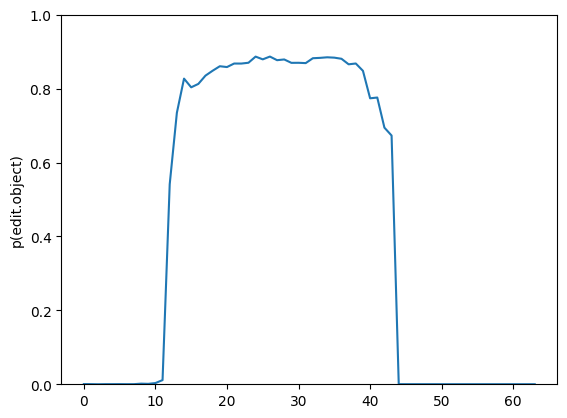

In [9]:
import matplotlib.pyplot as plt

plt.plot(layers, edit_ans_proba)
plt.ylim(0, 1)
plt.ylabel("p(edit.object)")

2024-01-11 12:04:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb7585290c0>
2024-01-11 12:04:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:04:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:04:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:04:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


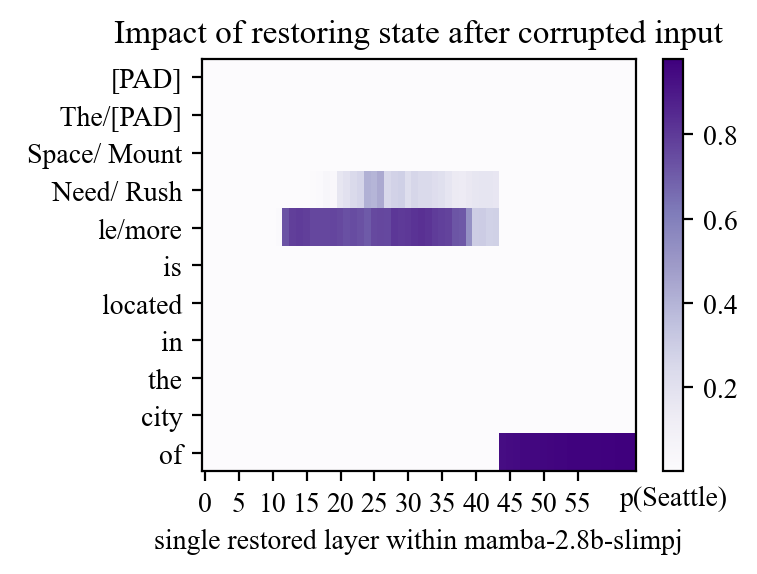

In [20]:
from src.functional import predict_next_token

prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

subject = "The Space Needle"
prompt = prompt_template.format(subject)

from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap
from src.hooking.mamba import MambaBlock_Hook_Points


indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt,
    subject = subject,
    alt_subject="Mount Rushmore",
)

plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])


--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_up_proj'
2024-01-11 12:06:33 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb7584881f0>
2024-01-11 12:06:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:06:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:06:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:06:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


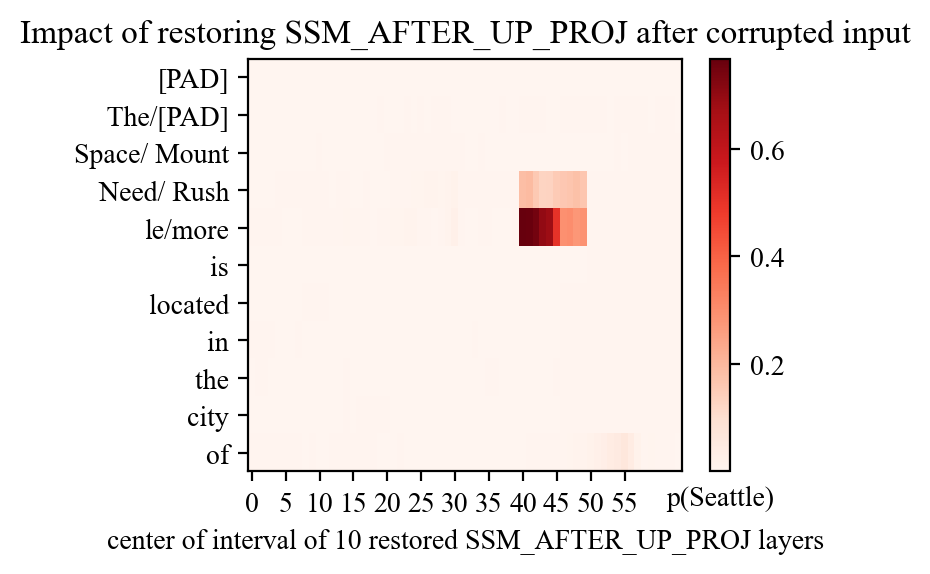

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_conv1D'
2024-01-11 12:07:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb75838ffd0>
2024-01-11 12:07:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:07:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:07:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:07:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


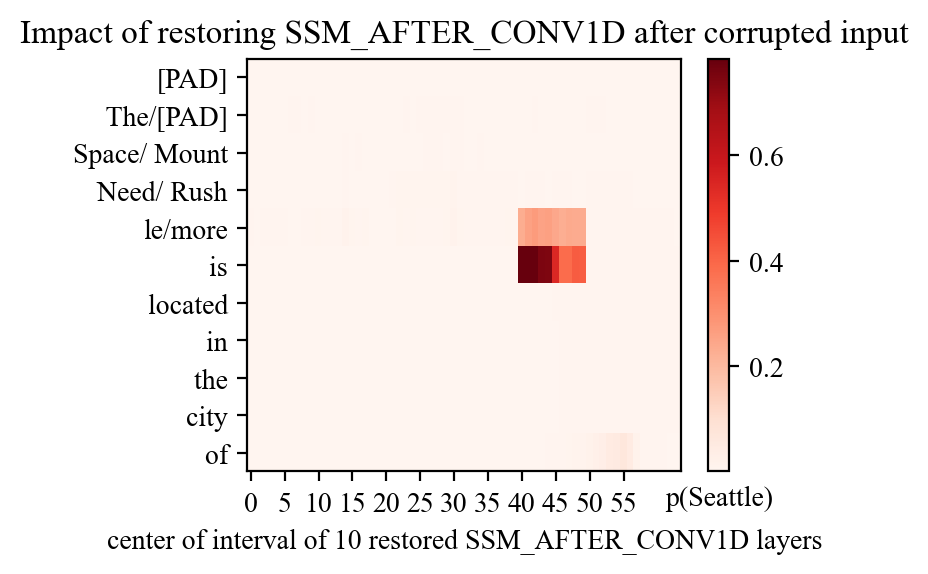

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_silu'
2024-01-11 12:09:20 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb7582e63e0>
2024-01-11 12:09:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:09:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:09:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:09:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


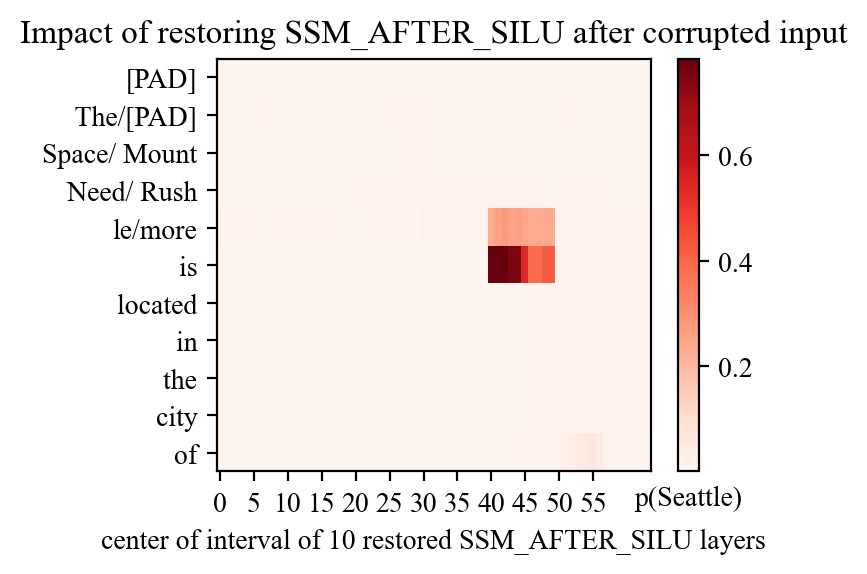

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_ssm'
2024-01-11 12:10:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb758218340>
2024-01-11 12:10:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:10:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:10:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:10:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


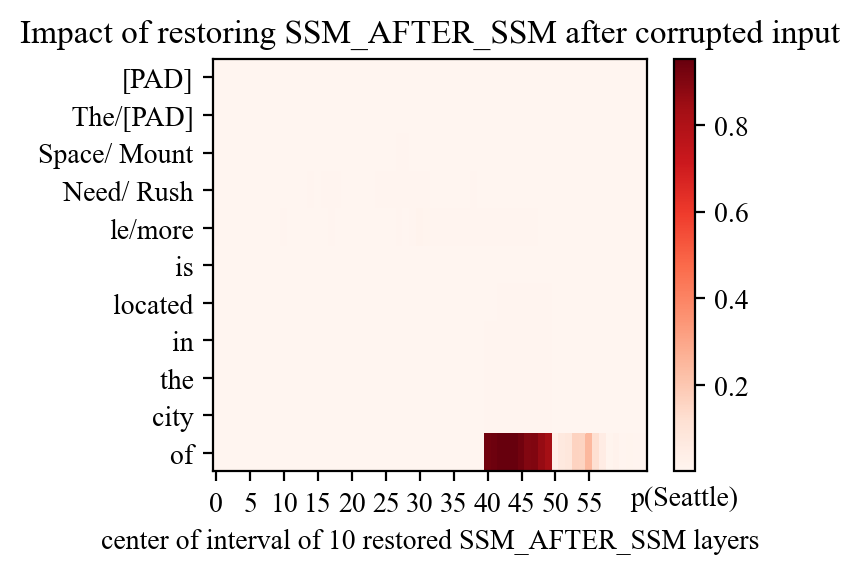

--------------------------------------------------------------------------------
mamba_block_hook='mlp_after_up_proj'
2024-01-11 12:12:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb758654070>
2024-01-11 12:12:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:12:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:12:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:12:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


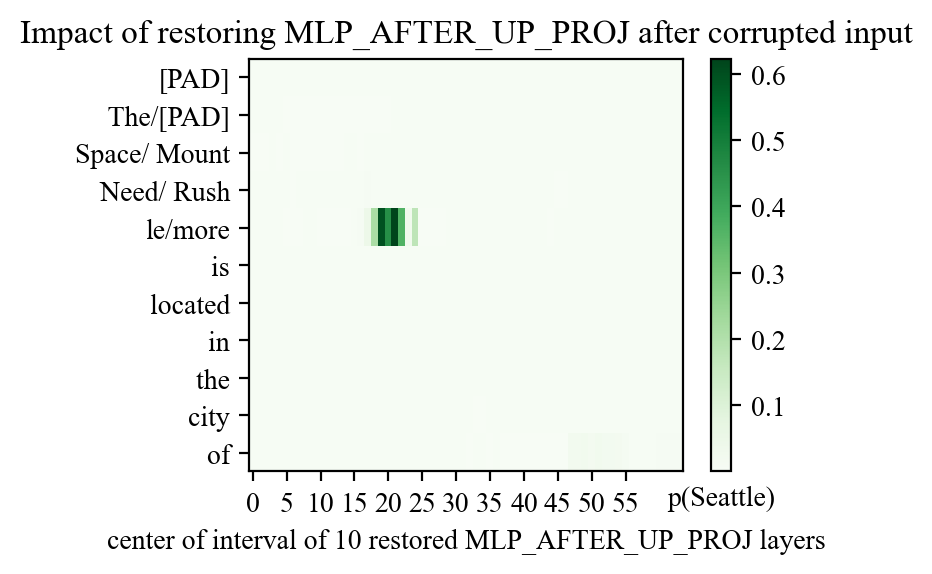

--------------------------------------------------------------------------------
mamba_block_hook='mlp_after_silu'
2024-01-11 12:13:26 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb76051d300>
2024-01-11 12:13:26 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:13:26 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:13:26 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:13:27 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


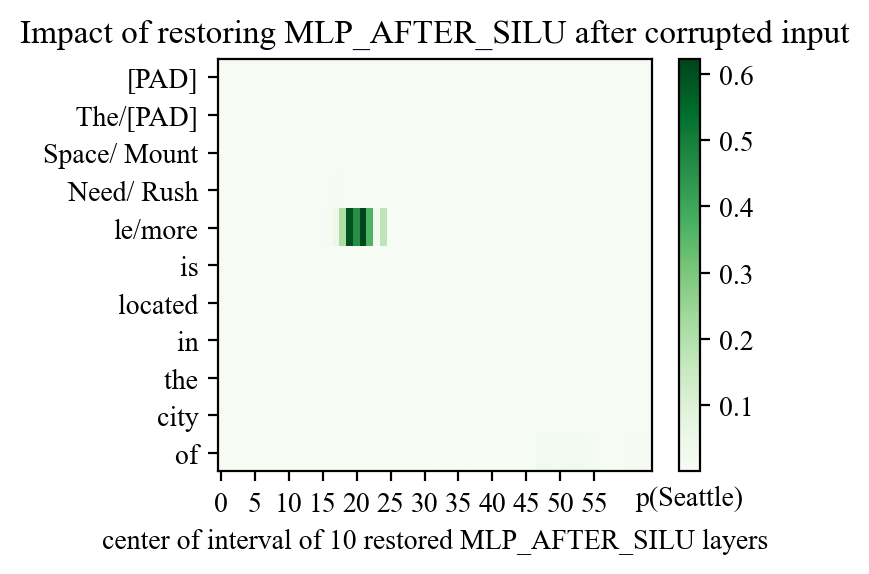

--------------------------------------------------------------------------------
mamba_block_hook='before_down_proj'
2024-01-11 12:14:49 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb7682116c0>
2024-01-11 12:14:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:14:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:14:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:14:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


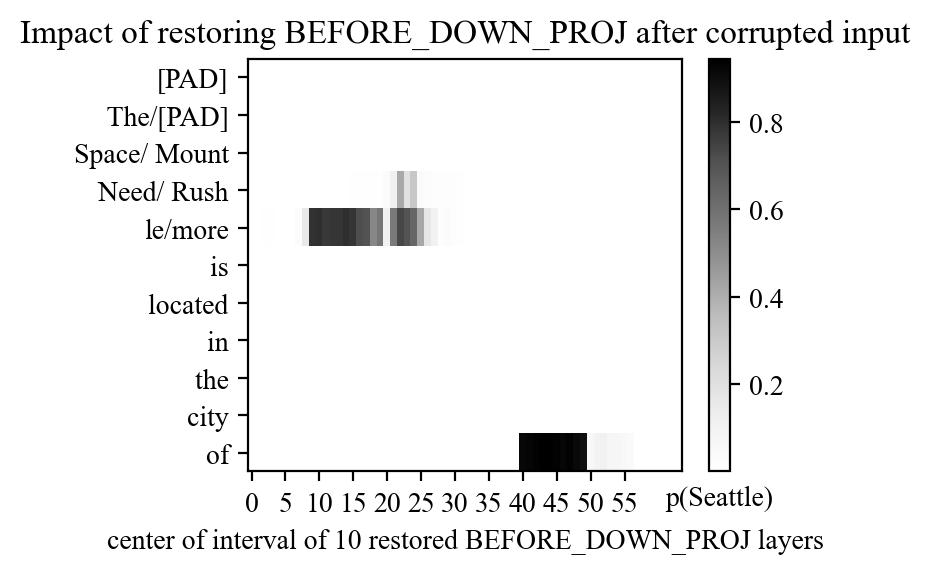

--------------------------------------------------------------------------------
mamba_block_hook='after_down_proj'
2024-01-11 12:16:11 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb7602ffaf0>
2024-01-11 12:16:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:16:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:16:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-11 12:16:11 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


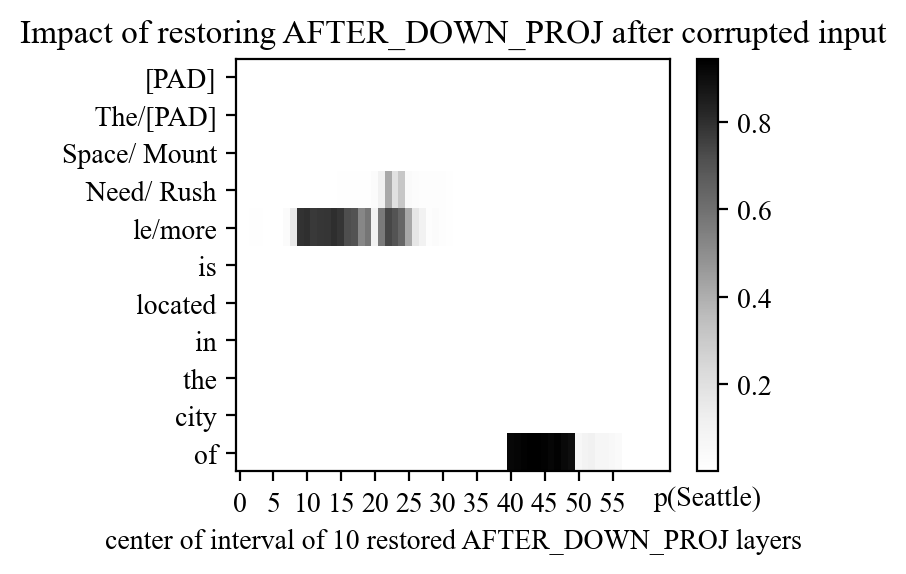

In [21]:
from src.hooking.mamba import MambaBlock_Hook_Points
from typing import get_args

for mamba_block_hook in get_args(MambaBlock_Hook_Points):
    print("-"*80)
    print(f"{mamba_block_hook=}")
    mt.reset_forward()
    indirect_effects = calculate_hidden_flow(
        mt = mt,
        prompt = prompt,
        subject = subject,
        alt_subject="Mount Rushmore",
        mamba_block_hook=mamba_block_hook
    )
    plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

In [19]:
predict_next_token(
    mt = mt,
    prompt = prompt_template.format("Mount Rushmore"),
)

[[PredictedToken(token=' Key', prob=0.739539623260498),
  PredictedToken(token=' the', prob=0.04133763536810875),
  PredictedToken(token=' South', prob=0.03129017725586891),
  PredictedToken(token=' C', prob=0.02044917643070221),
  PredictedToken(token=' Rapid', prob=0.01688564568758011)]]

In [23]:
mt.model

Mamba(
  (embedding): Embedding(50280, 2560)
  (layers): ModuleList(
    (0-63): 64 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=2560, out_features=10240, bias=False)
        (conv1d): Conv1d(5120, 5120, kernel_size=(4,), stride=(1,), padding=(3,), groups=5120)
        (x_proj): Linear(in_features=5120, out_features=192, bias=False)
        (dt_proj): Linear(in_features=160, out_features=5120, bias=True)
        (out_proj): Linear(in_features=5120, out_features=2560, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (norm_f): RMSNorm()
  (lm_head): Linear(in_features=2560, out_features=50280, bias=False)
)

In [34]:
prompt = prompt_template.format("Mount Rushmore")
tokenized = mt.tokenizer(prompt, return_tensors="pt").to(mt.device)

tokenized.pop("attention_mask")

with baukit.Trace(
    module = mt.model,
    layer=mt.layer_name_format.format(10),
) as trace:
    mt.model(**tokenized)

In [36]:
trace.output

tensor([[[-0.1250, -0.2500,  0.2324,  ...,  0.2404, -0.1639,  0.0892],
         [-0.0475, -0.2229,  0.2148,  ..., -0.1306,  0.2286, -0.0979],
         [-0.0310, -0.0793,  0.1050,  ..., -0.0080, -0.1514, -0.2200],
         ...,
         [ 0.0329, -0.0161, -0.0412,  ..., -0.0130, -0.0031,  0.0376],
         [ 0.0458, -0.0787, -0.0183,  ..., -0.1581, -0.2079,  0.0117],
         [ 0.0073, -0.0421, -0.0443,  ...,  0.0514,  0.0328,  0.0367]]],
       device='cuda:0', grad_fn=<AddBackward0>)